## setup

In [34]:
! pip install tensorflow numpy matplotlib pandas scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow as tf
import keras
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from keras.optimizers import Adam
import sklearn
import sklearn.metrics
from PIL import Image

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def transform_projection(image, rotation, shift, scale):
    # # Separate alpha if present
    # if image.shape[2] == 4:
    #     alpha = image[:,:,3]
    #     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    # else:
    #     alpha = None
    #     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]

    # ---- Parameters ----
    shift_x, shift_y = shift     # pixels
    rot_x, rot_y, rot_z = rotation   # degrees of 3D rotation

    # ---- Build Projection Matrix ----
    f = 500
    cx, cy = w//2, h//2

    

    # Define corner points in 3D
    corners_3d = np.array([
        [-w/2, -h/2, 0],
        [ w/2, -h/2, 0],
        [ w/2,  h/2, 0],
        [-w/2,  h/2, 0]
    ])

    # Apply rotation
    R = rotation_matrix(rot_x, rot_y, rot_z)
    rotated = corners_3d @ R.T

    # Apply scaling
    rotated *= scale

    # Project back to 2D
    projected = rotated.copy()
    projected[:,0] = f * projected[:,0] / (f + projected[:,2]) + cx + shift_x
    projected[:,1] = f * projected[:,1] / (f + projected[:,2]) + cy + shift_y

    # Warp perspective
    src_pts = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=np.float32)
    dst_pts = projected[:,:2].astype(np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    output = cv2.warpPerspective(image, M, (w+200, h+200))
    return output

def rotation_matrix(rx, ry, rz):
        rx, ry, rz = np.deg2rad([rx, ry, rz])
        Rx = np.array([[1, 0, 0],
                    [0, np.cos(rx), -np.sin(rx)],
                    [0, np.sin(rx),  np.cos(rx)]])
        Ry = np.array([[ np.cos(ry), 0, np.sin(ry)],
                    [0, 1, 0],
                    [-np.sin(ry), 0, np.cos(ry)]])
        Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                    [np.sin(rz),  np.cos(rz), 0],
                    [0, 0, 1]])
        return Rz @ Ry @ Rx


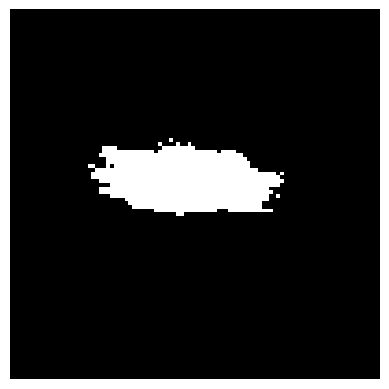

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

focus = 'snow'  # Change to 'random', 'mud', or 'snow' as needed


if focus == 'random':
    texture = np.random.randint(0, 256, (16, 16, 3), dtype=np.uint8)
elif focus == 'mud':
    texture = np.array(Image.open('textures/mud.png').convert('RGB').resize((100, 100), resample=Image.NEAREST))
elif focus == 'snow':
    texture = np.array(Image.open('textures/snow.png').convert('RGB').resize((100, 100), resample=Image.NEAREST))




# COMMENT THIS OUT IF YOU WANT TO TILE THE TEXTURE REPEATEDLY OVER 500x500 AREA
# texture = np.array(
#     Image.fromarray(texture).resize((500, 500), resample=Image.NEAREST)
# )

plt.imshow(texture)
plt.axis('off')
plt.show()


In [60]:
# # Tile the texture repeatedly over the 500x500 image
# tile_rows = 500 // texture.shape[0] + 1
# tile_cols = 500 // texture.shape[1] + 1

# tiled_texture = np.tile(texture, (tile_rows, tile_cols, 1))[:500, :500, :]

In [66]:
import numpy as np

canvas = np.zeros((500, 500, 3), dtype=texture.dtype)
tex_h, tex_w = texture.shape[:2]

np.random.seed(42)  # For reproducibility

for y in range(0, 500, tex_h + np.random.randint(0, 30)):
    for x in range(0, 500, tex_w + np.random.randint(0, 30)):
        y_end = min(y + tex_h, 500)
        x_end = min(x + tex_w, 500)
        # Compute region to paste
        region_h = y_end - y
        region_w = x_end - x
        canvas[y:y_end, x:x_end] = texture[:region_h, :region_w]

tiled_texture = canvas

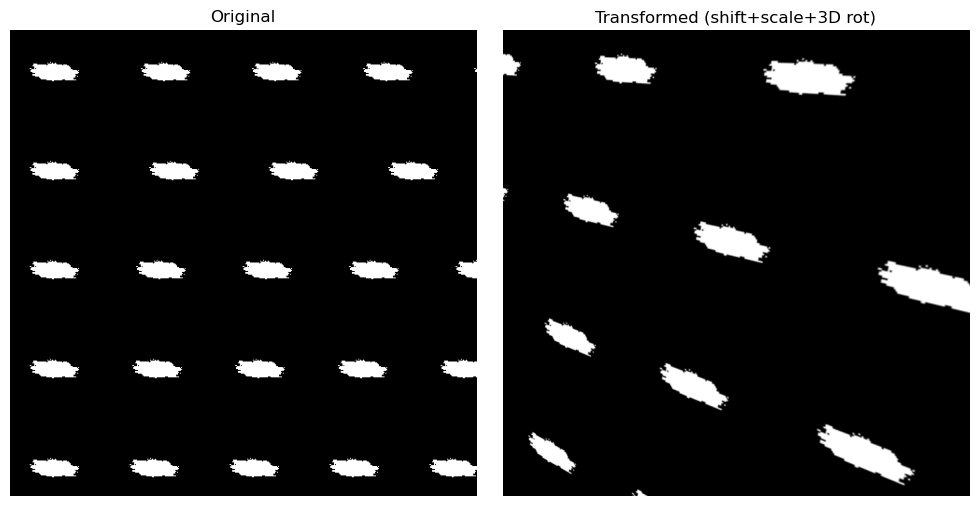

In [67]:
from random import randint



rotation = (randint(0,10), randint(0,20), randint(0,45))

transformed_tex = transform_projection(tiled_texture, rotation, (40, 40), scale = 2.2) # scale = 1.0 --> no scaling

# ---- Display ----
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(tiled_texture)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Transformed (shift+scale+3D rot)")
plt.imshow(transformed_tex)
plt.axis("off")

plt.tight_layout()
plt.show()

In [68]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = keras.preprocessing.image.load_img(path, target_size=image_size)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')

Loading validation datasets...


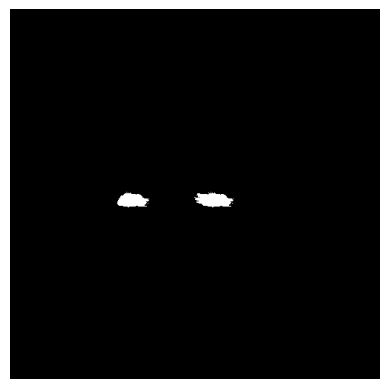

In [69]:
mask = np.any(val_eta_exp[65] > 0.01, axis=-1, keepdims=True)  # Shape: (500, 500, 1)

# Apply texture to masked regions
texture_mask = np.where(mask, tiled_texture, 0.0)

plt.imshow(texture_mask.astype(np.uint8))
plt.axis('off')
plt.show()


In [70]:
def predict_and_display(model, ref, tex, cross_ref):
    outputs = model.predict([ref, tex])

    # Compute intersection (where rendered and reference are nearly equal)
    intersection_mask = np.isclose(cross_ref, ref, atol=1e-2)

    # Overlay: only keep intersecting pixels in prediction
    overlay_preds = np.where(intersection_mask, ref, outputs[0])

    plt.imshow(overlay_preds[0])
    plt.axis('off')
    plt.title('Model Output')
    plt.show()


model = keras.models.load_model('models/k3_12epch_wo_custom_loss_model.h5', compile=False)

input1 = np.expand_dims(val_x_ref[65], axis=0)  # shape: (1, 500, 500, 3)
input2 = np.expand_dims(texture_mask, axis=0)  # shape: (1, 500, 500, 3)
cross_ref = np.expand_dims(val_x_ren[65], axis=0)  # shape: (1, 500, 500, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


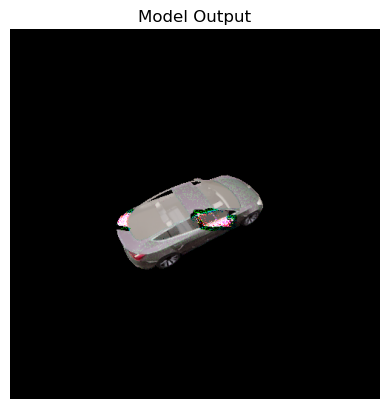

In [71]:
predict_and_display(model, input1, input2, cross_ref)

In [ ]:
# add object recognition model
# compute losses of all saved models - DONE
# real-word conditions textures (snow, dirt, etc.) - DONE
# MAYBE RE-TRAIN MODELS WITH LESS NODES? COLOURISARION ISSUES

: 

In [ ]:
import os
mse_dict = {}

for model_path in os.listdir('models'):
    print(f"Processing model: {model_path}")
    
    if model_path == 'k3_50epch_custom_loss_w_fit().h5':
        class CustomModel(tf.keras.Model):
            def train_step(self, data):
                (x_ref, eta_exp), y_true = data

                with tf.GradientTape() as tape:
                    outputs = self([x_ref, eta_exp], training=True)
                    y_pred = outputs["prediction"]
                    x_ref_passthrough = outputs["x_ref_passthrough"]

                    # Calculate intersection mask
                    epsilon = 1e-2
                    mask = tf.cast(tf.abs(y_true - x_ref_passthrough) > epsilon, tf.float32)
                    sq_diff = tf.square(y_true - y_pred)
                    masked_sq_diff = sq_diff * mask
                    loss = tf.reduce_sum(masked_sq_diff) / (tf.reduce_sum(mask) + 1e-8)

                # Compute gradients
                trainable_vars = self.trainable_variables
                gradients = tape.gradient(loss, trainable_vars)
                self.optimizer.apply_gradients(zip(gradients, trainable_vars))

                return {"loss": loss}
        
        model = keras.models.load_model(f'models/{model_path}', compile=False, custom_objects={'CustomModel': CustomModel})
        # Predict
        preds = model.predict([val_x_ref, val_eta_exp])['prediction']

    else:
        # Load the model
        model = keras.models.load_model(f'models/{model_path}', compile=False)

        # Predict
        preds = model.predict([val_x_ref, val_eta_exp])

    # Compute intersection (where rendered and reference are nearly equal)
    intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

    # Overlay: only keep intersecting pixels in prediction
    overlay_preds = np.where(intersection_mask, val_x_ref, preds)
    # overlay_preds = np.where(intersection_mask, preds, 0.0)

    avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


    print("Average MSE: ", avg_mse)

    mse_dict[model_path] = avg_mse

     

Processing model: k1_50epch_custom_loop_loss_model.h5


In [ ]:
print("MSE Dictionary: ", mse_dict)
print("Models sorted by MSE:")
for model_path, mse in sorted(mse_dict.items(), key=lambda x: x[1]):
    print(f"{model_path}: {mse}") 

MSE Dictionary:  {'k1_50epch_custom_loop_loss_model.h5': 0.00032804798684082925, 'k2_50epch_custom_loop_loss_model.h5': 0.0003320811374578625, 'k3_100epch_wo_custom_loss_model.h5': 0.00029607475153170526, 'k3_12epch_wo_custom_loss_model.h5': 0.0003135498845949769, 'k3_25epch_wo_custom_loss_model.h5': 0.000320262712193653, 'k3_50epch_custom_loss_w_fit().h5': 0.000370358262443915, 'k3_50epch_wo_custom_loss_model.h5': 0.0002989546919707209}
Models sorted by MSE:
k3_100epch_wo_custom_loss_model.h5: 0.00029607475153170526
k3_50epch_wo_custom_loss_model.h5: 0.0002989546919707209
k3_12epch_wo_custom_loss_model.h5: 0.0003135498845949769
k3_25epch_wo_custom_loss_model.h5: 0.000320262712193653
k1_50epch_custom_loop_loss_model.h5: 0.00032804798684082925
k2_50epch_custom_loop_loss_model.h5: 0.0003320811374578625
k3_50epch_custom_loss_w_fit().h5: 0.000370358262443915


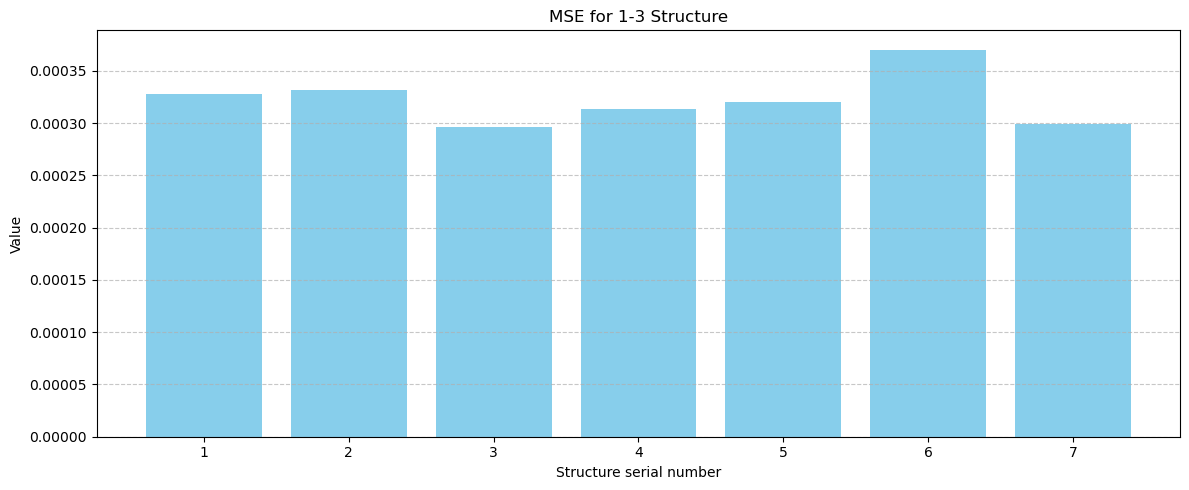

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))
plt.bar([1,2,3,4,5,6,7], list(mse_dict.values()), color='skyblue')
plt.xlabel('Structure serial number')
plt.ylabel('Value')
plt.title('MSE for 1-3 Structure')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()